# Project Overview

The goal: 

Detect what is truthful versus deceptive in terms of hotel reviews. 

## 1. Load Packages + Set Up

In [1]:
import pandas as pd
import numpy as np 
import warnings
import sklearn as sk
import seaborn as sns; sns.set(color_codes=True)
import gensim as gs
import re
from collections import defaultdict
from sklearn.lda import LDA
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
%matplotlib inline
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))
%qtconsole

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


## Load Packages from previous NLP work

In [2]:
# 2. Prep Data
def prep_nlp(data_to_prep, stop_words_in, symbols_to_remove):
    clean = data_to_prep.str.lower().str.split()
    clean = clean.apply(lambda x: [item for item in x if item not in stop_words_in])
    clean = clean.tolist()
    clean = [[re.sub(symbol_remover,'',word) for word in text] for text in clean]
    return clean

def build_model(train_data, topic_n):
    frequency = defaultdict(int)
    for text in train_data:
        for token in text:
            frequency[token] += 1
    # get freq > 1
    word_freq_1plus = [[x for x in words if frequency[x] > 1] for words in train_data]
    # Create dictionary
    dictionary = gs.corpora.Dictionary(word_freq_1plus)
    # Create Corpus
    corpus = [dictionary.doc2bow(text) for text in train_data]
    # corpus to tfidf
    tfidf = gs.models.TfidfModel(corpus) 
    corp_tf = tfidf[corpus] 
    # Unsupervised Component. Reduce space into 300 topics. 
    topic_n = topic_n
    lsi = gs.models.LsiModel(corp_tf, id2word=dictionary, num_topics = topic_n)
    corp_topics = lsi[corp_tf] 
    return corp_topics, dictionary, tfidf, lsi  

def train_model(topic_vec, column, target, append = True):
    if isinstance(append,pd.DataFrame) == False:
        x = pd.DataFrame([dict(row) for row in topic_vec[0]])
        y = (column == target).astype(int) 
        lda = LDA()
        mask = np.array([~np.isnan(row).any() for row in x.values])
        x_masked = x[mask]
        y_masked = y[mask]
        lda = lda.fit(x_masked,y_masked)
    else: 
        x = pd.DataFrame([dict(row) for row in topic_vec[0]])
        y = (column == target).astype(int) 
        lda = LDA()
        mask = np.array([~np.isnan(row).any() for row in x.values])
        x_masked = x[mask]
        y_masked = y[mask]
        append_masked = append[mask]
        x_masked = pd.concat(
            [x_masked.reset_index(drop=True),
            append_masked.reset_index(drop=True)],
            axis = 1)
        lda = lda.fit(x_masked,y_masked)
    return lda,x_masked,y_masked, topic_vec[1],topic_vec[2], topic_vec[3]

def predict_unseen(content_in, outcome_in, stop_words_in, trained_model_in, symbols_to_remove, target):

    dictionary_in = trained_model_in[3]
    tfidf_in = trained_model_in[4]
    lsi_in = trained_model_in[5]
    lda_in = trained_model_in[0]
    new_doc_in_content = pd.Series(content_in)
    new_doc_in_outcome = pd.Series(outcome_in)
    
    query = prep_nlp(new_doc_in_content, stop_words_in, symbols_to_remove)
    query_bow = [dictionary_in.doc2bow(corp) for corp in query]
    query_tf = tfidf_in[query_bow] 
    
    x_2 = pd.DataFrame([dict(tf) for tf in lsi_in[query_tf]])
    mask = np.array([~np.isnan(row).any() for row in x_2.values])
    x_2masked = x_2[mask]
    y_2 = (new_doc_in_outcome == target).astype(int) 
    
    y_2masked = np.array(y_2[mask])
    x_2masked = lda_in.predict(x_2masked)
    
    return x_2masked,y_2masked

def performance(result_x, result_y):
    actual_positive = result_y == 1
    actual_negative = result_y ==0
    true_positives = result_x[actual_positive] == 1
    false_positives = result_x[actual_negative] == 1
    true_negatives = result_x[actual_negative] == 0
    false_negatives = result_x[actual_positive] == 0
    #A. Accuracy = (TP + TN)/(TP + TN + FP + FN)
    #B. Precision = TP/(TP + FP)
    #C. Recall = TP/(TP + FN)
    accuracy = sum((result_x == result_y))/len(result_y)
    precision = sum(true_positives) / (sum(true_positives) + sum(false_positives))
    recall = sum(true_positives) / (sum(true_positives) + sum(false_negatives))
    return [accuracy, precision, recall, len(result_x)]

## Norvig's Spellchecker
Using Norvig's Spellchecker to tag misspellings
http://norvig.com/spell-correct.html

In [34]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def sp_check(word): 
    "Most probable spelling correction for word."
    # return a logical
    return max(candidates(word), key=P) == word

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [35]:
def correctness(text_in):
    text_in = text_in.str.lower().str.split()
    return [[sum(sp_check(y) for y in x)/len(x)] for x in text_in]

## 2. Read Data, Describe
- Look at first five rows, then last five rows


In [36]:
data_in = pd.read_csv('deceptive-opinion.csv')


deceptive   hotel  polarity       source  \
0  truthful  conrad  positive  TripAdvisor   
1  truthful   hyatt  positive  TripAdvisor   
2  truthful   hyatt  positive  TripAdvisor   
3  truthful    omni  positive  TripAdvisor   
4  truthful   hyatt  positive  TripAdvisor   

                                                text  
0  We stayed for a one night getaway with family ...  
1  Triple A rate with upgrade to view room was le...  
2  This comes a little late as I'm finally catchi...  
3  The Omni Chicago really delivers on all fronts...  
4  I asked for a high floor away from the elevato...

deceptive             hotel  polarity source  \
1595  deceptive  intercontinental  negative  MTurk   
1596  deceptive            amalfi  negative  MTurk   
1597  deceptive  intercontinental  negative  MTurk   
1598  deceptive            palmer  negative  MTurk   
1599  deceptive            amalfi  negative  MTurk   

                                                   text  
1595  Problems started when I booked the InterContin...  
1596  The Amalfi Hotel has a beautiful website and i...  
1597  The Intercontinental Chicago Magnificent Mile ...  
1598  The Palmer House Hilton, while it looks good i...  
1599  As a former Chicagoan, I'm appalled at the Ama...

In [43]:
candidates('hellllllo')

['hellllllo']

In [25]:
perc_correct = correctness(data_in.text)
perc_correct = pd.DataFrame(perc_correct)

## 3. Explore Data
Questions:
1. Is there a difference in review lengths by polarity, deception, and hotel?
2. Is there a difference in terms of words across hotels?

In [4]:
data_in.pivot_table(
    columns=['deceptive','polarity'],
    index = ['hotel'],
    aggfunc = len).fillna(0)

source                                 text           \
deceptive        deceptive          truthful          deceptive            
polarity          negative positive negative positive  negative positive   
hotel                                                                      
affinia                 20       20       20       20        20       20   
allegro                 20       20       20       20        20       20   
amalfi                  20       20       20       20        20       20   
ambassador              20       20       20       20        20       20   
conrad                  20       20       20       20        20       20   
fairmont                20       20       20       20        20       20   
hardrock                20       20       20       20        20       20   
hilton                  20       20       20       20        20       20   
homewood                20       20       20       20        20       20   
hyatt                   20       20       20       20        20       20   
intercontinental        20       20       20       20        20       20   
james                   20       20       20       20        20       20   
knickerbocker           20       20       20       20        20       20   
monaco                  20       20       20       20        20       20   
omni                    20       20       20       20        20       20   
palmer                  20       20       20       20        20       20   
sheraton                20       20       20       20        20       20   
sofitel                 20       20       20       20        20       20   
swissotel               20       20       20       20        20       20   
talbott                 20       20       20       20        20       20   

                                    
deceptive        truthful           
polarity         negative positive  
hotel                               
affinia                20       20  
allegro                20       20  
amalfi                 20       20  
ambassador             20       20  
conrad                 20       20  
fairmont               20       20  
hardrock               20       20  
hilton                 20       20  
homewood               20       20  
hyatt                  20       20  
intercontinental       20       20  
james                  20       20  
knickerbocker          20       20  
monaco                 20       20  
omni                   20       20  
palmer                 20       20  
sheraton               20       20  
sofitel                20       20  
swissotel              20       20  
talbott                20       20

### 3a. Deceptive vs Truthful Review Length


In [6]:
grouped_data = data_in.groupby(['deceptive','polarity']).apply(mean_len, mean = True)
grouped_hotel= pd.DataFrame(grouped_data)
grouped_hotel = grouped_hotel.reset_index()
grouped_hotel.columns.values[2] = 'length'
_ = sns.barplot(x = 'deceptive', y = 'length', hue = 'polarity', data = grouped_hotel)

#### Run Test on Deceptive and Truthful Length
Results below show that there is not a stat sig difference. 

In [7]:
from scipy.stats import ttest_ind
pd.set_option('display.float_format', lambda x: '%.3f' % x)

positive = data_in[data_in.deceptive == 'deceptive'].text.str.len()
negative = data_in[data_in.deceptive == 'truthful'].text.str.len()

result = ttest_ind(positive,negative)
result

Ttest_indResult(statistic=-1.2520931090803307, pvalue=0.21071916472895064)

### 3b.Positive and Negative Polarity Review Length

In [8]:
grouped_data = data_in.groupby('polarity').apply(mean_len, mean = True)
grouped_polarity= pd.DataFrame(grouped_data)
grouped_polarity = grouped_polarity.reset_index()
grouped_polarity.columns.values[1] = 'length'
_ = sns.barplot(x = 'polarity', y = 'length', hue = 'polarity', data = grouped_polarity)

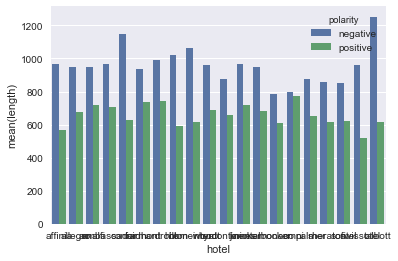

In [9]:
grouped_data = data_in.groupby(['hotel','polarity']).apply(mean_len, mean = True)
grouped_hotel= pd.DataFrame(grouped_data)
grouped_hotel = grouped_hotel.reset_index()
grouped_hotel.columns.values[2] = 'length'
_ = sns.barplot(x = 'hotel', y = 'length', hue = 'polarity', data = grouped_hotel)

#### Run Test on Positive and Negative Polarity
results below show that there is a stat sig difference, and that positive values are indeed shorter in length.

In [10]:
from scipy.stats import ttest_ind
pd.set_option('display.float_format', lambda x: '%.3f' % x)

positive = data_in[data_in.polarity == 'positive'].text.str.len()
negative = data_in[data_in.polarity == 'negative'].text.str.len()

result = ttest_ind(positive,negative)
result

Ttest_indResult(statistic=-13.507204854821099, pvalue=1.8968798894685588e-39)

### 3c. Are words different? Between Deceptive vs Truthful?

Seems that the top words are similar. But, lower frequency words have more typos when it comes to truthful reviews.

In [11]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
symbol_remover = '\\!|\\.|\\,|\\-'


def word_freq(text_in):
    text_in = text_in.str.lower().str.split()
    text_in = text_in.apply(lambda x: [item for item in x if item not in stop])
    text_in = [[re.sub(symbol_remover,'',word) for word in text] for text in text_in]
    frequency = defaultdict(int)
    for text in text_in:
        for token in text:
            frequency[token] += 1

    result = pd.DataFrame.from_dict(frequency,orient='index').reset_index()
    result.columns.values[1] = 'freq'
    
    return result.sort_values('freq',ascending = 0)
deceptive_word_freq = word_freq(data_in[data_in.deceptive == 'deceptive'].text)
truthful_word_freq = word_freq(data_in[data_in.deceptive == 'truthful'].text)

display(deceptive_word_freq[deceptive_word_freq.freq > 1].head(25))
display(deceptive_word_freq[deceptive_word_freq.freq > 1].tail(25))
display(truthful_word_freq[truthful_word_freq.freq >1].head(25))
display(truthful_word_freq[truthful_word_freq.freq >1].tail(25))

index  freq
85        hotel  1791
22         room  1375
3       chicago  1009
92         stay   702
54        would   473
8       service   426
108       staff   395
98          one   344
156       rooms   341
43         like   327
47       stayed   315
240       great   314
10         time   303
263         get   259
549        desk   242
99        could   238
120          us   235
60         even   234
75   experience   221
390       night   215
231       place   206
284        back   206
35         also   203
94        clean   202
297        nice   200

index  freq
2723           kit'     2
1339          ethan     2
6570           21st     2
5352          field     2
2732          tiled     2
4976           pull     2
5161       patterns     2
4658          heavy     2
2696          snack     2
5393           turd     2
1338           been     2
2108            be)     2
1757          youve     2
2677         tables     2
5227        grilled     2
7042        ashtray     2
5325          musky     2
1760  affordability     2
2680             dj     2
2676     excellence     2
1762     glamourous     2
1522           road     2
2683          giant     2
5229       sandwich     2
6885      sleepless     2

index  freq
101     hotel  1461
13       room  1352
243      stay   592
64      great   536
280             480
56    chicago   471
52      would   442
175     staff   433
36    service   369
0      stayed   347
1         one   346
32   location   336
357        us   335
109     rooms   332
2       night   300
443      nice   281
145       get   280
81        bed   262
200      desk   254
49       good   249
61       also   221
43       even   221
507      like   220
296  bathroom   215
401     could   215

index  freq
8051        proper     2
5888         full)     2
597            $48     2
8414  occasionally     2
8667         plus)     2
2198          dave     2
3561         known     2
3575          kiss     2
3556      exciting     2
2686          did)     2
5895           spg     2
5765         inept     2
3552          40th     2
2774             x     2
3549        listed     2
6423      priority     2
3554         she's     2
2215       storing     2
6766      reliable     2
5762          day'     2
3382          (you     2
8132        cooler     2
6425       honesty     2
2599     surpassed     2
2772     regarding     2

### 4. Create Train, validate, test Data

In [12]:
train, validate, test = np.split(data_in.sample(frac=1,random_state=100), [int(.6*len(data_in)), int(.8*len(data_in))])

### 5. Create Baseline Model

In [13]:
# set stop words / symbols to remove
stopwords_remove = ""
symbols_remove = ""

In [14]:
baseline_prepped = prep_nlp(data_to_prep=train.text,stop_words_in=stopwords_remove,symbols_to_remove=symbols_remove)
baseline_built = build_model(train_data=baseline_prepped, topic_n=300)
baseline_trained = train_model(append=False, column=train.deceptive, target='deceptive', topic_vec=baseline_built)

In [15]:
# run model on validate data
predicted_validate = predict_unseen(
    content_in = validate.text,
    outcome_in = validate.deceptive,
    stop_words_in = stopwords_remove,
    symbols_to_remove = symbols_remove,
    trained_model_in = baseline_trained,
    target = 'deceptive')

# run model on validate data


predicted_test = predict_unseen(
    content_in = test.text,
    outcome_in = test.deceptive,
    stop_words_in = stopwords_remove,
    symbols_to_remove = symbols_remove,
    trained_model_in = baseline_trained,
    target = 'deceptive')

performance_on_test = performance(
    result_x=predicted_test[0],
    result_y=predicted_test[1])

# get performance
performance_on_validate = performance(
    result_x=predicted_validate[0],
    result_y=predicted_validate[1])

# show results in a table
results_out = pd.DataFrame({
    'Train':performance_on_train,
    'Validate':performance_on_validate,
    'test':performance_on_test
}).set_index(
    [['Accuracy','Precision','Recall','N Size'],
     ['% Deceptive / Genuine Correct','% Predicted Spam Actually Deceptive','% Deceptive Detected','']])
results_out

NameError: name 'performance_on_train' is not defined